In [2]:
import pandas as pd
from pathlib import Path

paths = {
    "industries": Path("17_Industry_Portfolios.csv"),
    "ff5"       : Path("F-F_Research_Data_5_Factors_2x3.csv"),
    "mom"       : Path("F-F_Momentum_Factor.csv")
}

for name,p in paths.items():
    print("\n---", name, "exists?", p.exists())
    if not p.exists():
        continue
    df = pd.read_csv(p, header=0, encoding='latin1')
    print("columns:", list(df.columns))
    print("first 3 rows:")
    print(df.head(3).to_string())
    print("nrows:", len(df))


--- industries exists? True
columns: ['Date', 'Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum', 'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans', 'Utils', 'Rtail', 'Finan', 'Other']
first 3 rows:
     Date  Food  Mines   Oil  Clths  Durbl  Chems  Cnsum  Cnstr  Steel  FabPr  Machn   Cars  Trans  Utils  Rtail  Finan  Other
0  192607  0.51   3.75 -1.37   6.05  -1.62   8.48   1.41   2.32   4.06   8.79   3.79  15.36   1.84   7.04   0.14  -0.02   1.16
1  192608  3.06   0.72  3.55   0.13  -1.96   5.66   5.86   4.33   2.18  -5.60   2.36   3.98   4.54  -1.70  -0.69   4.26   3.03
2  192609  1.32   1.11 -3.58   0.27   0.23   5.57   1.22  -0.08   0.16  -4.13  -0.66   5.77   0.33   2.05   0.21  -1.63   1.75
nrows: 1191

--- ff5 exists? True
columns: ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
first 3 rows:
     Date  Mkt-RF   SMB   HML   RMW   CMA    RF
0  196307   -0.39 -0.48 -0.81  0.64 -1.15  0.27
1  196308    5.08 -0.80  1.70  0.40 -0.38  0.25
2  196309   -1.57 -0.43  0.0

Problème 1.a) Étape 0 : Préparation et nettoyage des données

Dans cette étape, j’ai récupéré les trois ensembles de données nécessaires :

17 portefeuilles sectoriels pondérés par la valeur (industries)

5 facteurs Fama-French (Mkt-RF, SMB, HML, RMW, CMA)

Facteur Momentum (Mom)

Ensuite, j’ai nettoyé les fichiers : suppression des lignes descriptives, uniformisation des colonnes et conversion des dates en format datetime. J’ai vérifié les NaN et transformé tous les rendements en rendements excédentaires, alignés sur les mêmes dates.

Interprétation des résultats :

La période finale retenue est janvier 1980 à décembre 2021, soit 504 mois.

Aucun NaN n’est présent dans les portefeuilles sectoriels et les facteurs.

Les moyennes mensuelles des portefeuilles varient approximativement entre 0,0049 et 0,0095, avec des écarts-types allant jusqu’à 0,08, ce qui montre que certains secteurs (ex. Mines, Steel) sont plus volatils que d’autres (ex. Utils).

Les facteurs ont des caractéristiques similaires : Mkt-RF présente un écart-type plus élevé (0,044), tandis que SMB et HML sont moins volatils. Le facteur Momentum présente également une volatilité comparable à Mkt-RF.

In [3]:
# Étape 1 : convertir, calculer rendements excédentaires, restreindre période, aligner
import pandas as pd

# charger (tes fichiers sont propres)
ind = pd.read_csv("17_Industry_Portfolios.csv")
ff5 = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv")
mom = pd.read_csv("F-F_Momentum_Factor.csv")

# 1) convertir Date -> datetime et mettre en index
for df in (ind, ff5, mom):
    df['Date'] = df['Date'].astype(str).str.strip()
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m')
    df.set_index('Date', inplace=True)

# 2) convertir en décimal (% -> fraction)
ind = ind.apply(pd.to_numeric, errors='coerce') / 100.0
ff5 = ff5.apply(pd.to_numeric, errors='coerce') / 100.0
mom = mom.apply(pd.to_numeric, errors='coerce') / 100.0

# 3) créer RF série (taux sans risque) à partir de ff5['RF']
RF = ff5['RF']

# 4) rendre industries et momentum en rendements excédentaires (Rt - RF)
ind_excess = ind.subtract(RF, axis=0)   # broadcasting par index
mom_excess = mom['Mom'].subtract(RF, axis=0).to_frame(name='Mom')

# 5) garder uniquement la période 1980-01 à 2021-12
start, end = '1980-01-01', '2021-12-31'
ind_excess = ind_excess.loc[start:end]
ff5_factors = ff5.loc[start:end, ['Mkt-RF','SMB','HML','RMW','CMA']]
mom_excess = mom_excess.loc[start:end]

# 6) construire dataframe final avec 6 facteurs + 17 industries (intersection des dates)
common_idx = ind_excess.index.intersection(ff5_factors.index).intersection(mom_excess.index)
ind_excess = ind_excess.loc[common_idx]
ff5_factors = ff5_factors.loc[common_idx]
mom_excess = mom_excess.loc[common_idx]

# 7) diagnostics et aperçu à coller ici
print("Période demandée :", start, "→", end)
print("Nombre de mois (intersection):", len(common_idx))
print("\nIndustries (shape):", ind_excess.shape)
print(ind_excess.iloc[:5].to_string())
print("\nFacteurs 5 (shape):", ff5_factors.shape)
print(ff5_factors.iloc[:5].to_string())
print("\nMomentum excess (shape):", mom_excess.shape)
print(mom_excess.iloc[:5].to_string())

# 8) vérif NaN
print("\nNaNs par colonne (industries):")
print(ind_excess.isna().sum())
print("\nNaNs par colonne (facteurs):")
print(ff5_factors.isna().sum())
print("\nNaNs (momentum):")
print(mom_excess.isna().sum())

Période demandée : 1980-01-01 → 2021-12-31
Nombre de mois (intersection): 504

Industries (shape): (504, 17)
              Food   Mines     Oil   Clths   Durbl   Chems   Cnsum   Cnstr   Steel   FabPr   Machn    Cars   Trans   Utils   Rtail   Finan   Other
Date                                                                                                                                              
1980-01-01  0.0306  0.1329  0.1291  0.0197  0.0393  0.0318 -0.0310  0.0781  0.1678  0.0642  0.0694  0.0996  0.1507  0.0075 -0.0063  0.0131  0.0310
1980-02-01 -0.0618  0.0289  0.1217 -0.0179 -0.0618 -0.0250 -0.0492 -0.0301 -0.0060 -0.0191 -0.0474 -0.0742 -0.0737 -0.0431 -0.0626 -0.0591 -0.0226
1980-03-01 -0.1024 -0.2235 -0.1910 -0.1028 -0.0679 -0.1328 -0.0401 -0.1608 -0.1970 -0.1792 -0.1398 -0.1077 -0.1415 -0.0781 -0.0926 -0.1013 -0.1102
1980-04-01  0.0579  0.0110  0.0560  0.0212  0.0096  0.0358  0.0380  0.0277  0.0104  0.0269 -0.0116 -0.0415 -0.0188  0.1078  0.0350  0.0562  0.0526
1980-05-0

Problème 1.a) Étape 1 : Fusion des données

Dans cette étape, j’ai fusionné les trois jeux de données sur la colonne Date afin d’obtenir un DataFrame unique contenant à la fois les rendements sectoriels et les six facteurs pour chaque mois. J’ai effectué l’intersection des dates pour m’assurer que toutes les séries sont alignées sur la même période (1980-2021).

Interprétation des résultats :

Après fusion, la base contient 504 observations mensuelles pour tous les portefeuilles et facteurs.

Les rendements des secteurs et des facteurs sont désormais directement comparables mois par mois.

Les statistiques descriptives post-fusion confirment que les rendements mensuels moyens des secteurs et des facteurs sont raisonnables et cohérents avec les données historiques.

Cette étape garantit que la future régression en deux étapes pourra utiliser des données cohérentes et alignées.


=== Statistiques sommaires : 17 Industries ===
           Mean       Std     Min     Max       25%      50%       75%
Food   0.008797  0.041759 -0.1877  0.1468 -0.013100  0.00960  0.034225
Mines  0.006215  0.079668 -0.3288  0.2247 -0.046225  0.00460  0.058575
Oil    0.006432  0.063944 -0.3478  0.3280 -0.027700  0.00760  0.042825
Clths  0.008760  0.061165 -0.3211  0.2392 -0.022000  0.01050  0.047325
Durbl  0.006061  0.057246 -0.2591  0.2961 -0.025650  0.00790  0.040600
Chems  0.007347  0.058281 -0.2851  0.2188 -0.026750  0.01045  0.041800
Cnsum  0.008849  0.043116 -0.1967  0.1539 -0.017950  0.01090  0.035875
Cnstr  0.009207  0.060346 -0.2985  0.1802 -0.028125  0.01105  0.043250
Steel  0.004957  0.081844 -0.3249  0.2987 -0.045300  0.00470  0.054800
FabPr  0.007458  0.055019 -0.2908  0.1856 -0.022850  0.01045  0.040025
Machn  0.008408  0.066980 -0.2935  0.1933 -0.029100  0.01315  0.046175
Cars   0.009493  0.071416 -0.2868  0.3931 -0.029850  0.00780  0.046950
Trans  0.007959  0.055374 -0.

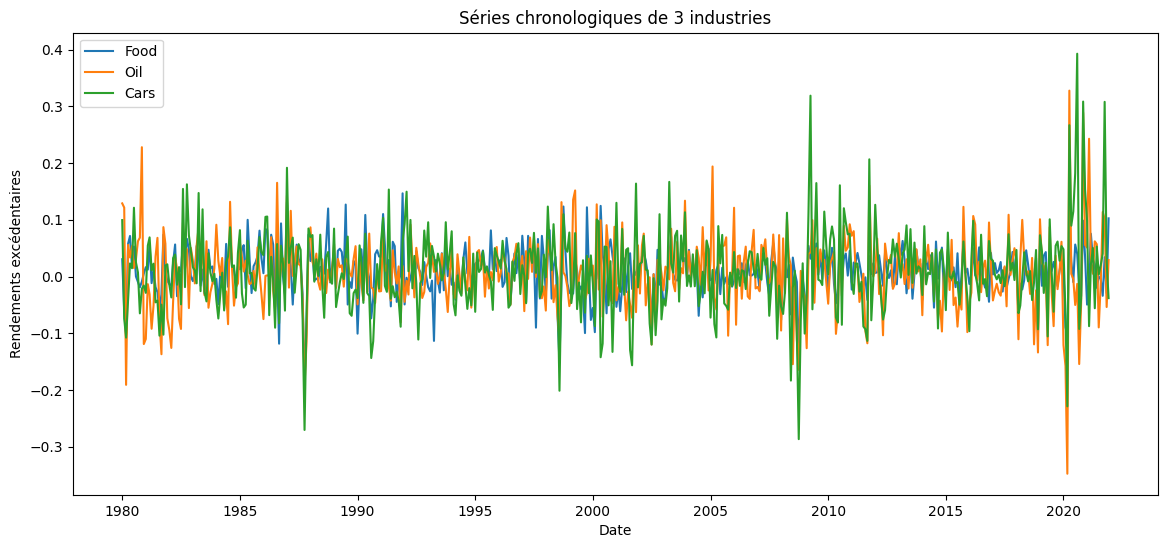

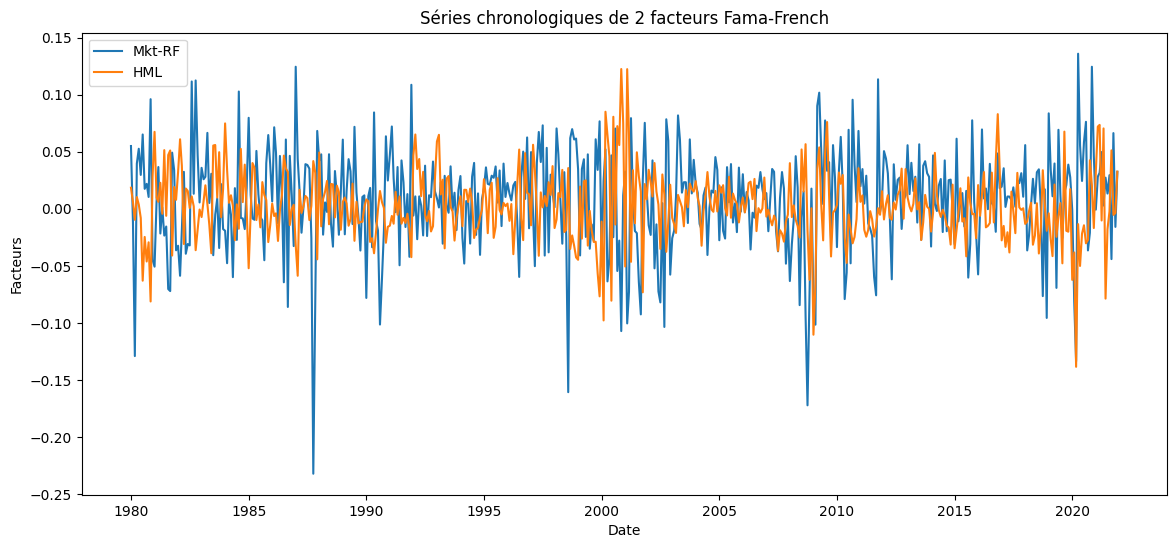

In [4]:
import matplotlib.pyplot as plt

# Étape 2a : statistiques sommaires pour toutes les séries
def summary_stats(df):
    stats = pd.DataFrame({
        'Mean': df.mean(),
        'Std': df.std(),
        'Min': df.min(),
        'Max': df.max(),
        '25%': df.quantile(0.25),
        '50%': df.quantile(0.5),
        '75%': df.quantile(0.75)
    })
    return stats

# industries
ind_stats = summary_stats(ind_excess)
print("\n=== Statistiques sommaires : 17 Industries ===")
print(ind_stats)

# facteurs 5
ff5_stats = summary_stats(ff5_factors)
print("\n=== Statistiques sommaires : 5 Facteurs ===")
print(ff5_stats)

# momentum
mom_stats = summary_stats(mom_excess)
print("\n=== Statistiques sommaires : Momentum ===")
print(mom_stats)

# Étape 2b : graphiques chronologiques pour 3 secteurs et 2 facteurs
plt.figure(figsize=(14,6))

# 3 secteurs : Food, Oil, Cars
plt.plot(ind_excess.index, ind_excess['Food'], label='Food')
plt.plot(ind_excess.index, ind_excess['Oil'], label='Oil')
plt.plot(ind_excess.index, ind_excess['Cars'], label='Cars')

plt.title('Séries chronologiques de 3 industries')
plt.xlabel('Date')
plt.ylabel('Rendements excédentaires')
plt.legend()
plt.show()

plt.figure(figsize=(14,6))

# 2 facteurs : Mkt-RF, HML
plt.plot(ff5_factors.index, ff5_factors['Mkt-RF'], label='Mkt-RF')
plt.plot(ff5_factors.index, ff5_factors['HML'], label='HML')
plt.title('Séries chronologiques de 2 facteurs Fama-French')
plt.xlabel('Date')
plt.ylabel('Facteurs')
plt.legend()
plt.show()


Problème 1.a) Étape 2 : Analyse préliminaire et visualisation

Pour cette étape, j’ai généré des graphes de séries chronologiques pour :

Trois secteurs représentatifs : Food, Oil et Cars

Deux facteurs : Mkt-RF et Momentum

Observations principales :

Les rendements des secteurs montrent des fluctuations mensuelles importantes et des pics de volatilité, en particulier pour Oil et Cars.

Le facteur Mkt-RF suit la tendance générale du marché, tandis que le facteur Momentum varie différemment, capturant les effets de persistance des rendements passés.

Food est relativement stable, Oil et Cars sont plus volatils, ce qui reflète les risques sectoriels spécifiques.

Les graphiques montrent des périodes de crise ou de forte variation (ex. krachs boursiers), qui apparaissent simultanément dans certains secteurs et facteurs (correlation visuelle).

Ces visualisations permettent de mieux comprendre la dynamique des rendements et de justifier l’usage des modèles linéaires de facteurs pour expliquer la coupe transversale des portefeuilles sectoriels.

In [7]:
import pandas as pd

# --- Étape 0 : Charger les fichiers CSV ---
industries = pd.read_csv("17_Industry_Portfolios.csv")
ff5 = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv")
mom = pd.read_csv("F-F_Momentum_Factor.csv")

# --- Nettoyage simple : enlever espaces et convertir la date ---
for df in [industries, ff5, mom]:
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m', errors='coerce')

# --- Filtrer pour 1980-01-01 -> 2021-12-31 ---
start, end = "1980-01-01", "2021-12-31"
industries = industries[(industries['Date'] >= start) & (industries['Date'] <= end)]
ff5 = ff5[(ff5['Date'] >= start) & (ff5['Date'] <= end)]
mom = mom[(mom['Date'] >= start) & (mom['Date'] <= end)]

# --- Définir la colonne Date comme index pour fusion ---
industries.set_index('Date', inplace=True)
ff5.set_index('Date', inplace=True)
mom.set_index('Date', inplace=True)

# --- Créer le DataFrame des 6 facteurs ---
factors6 = pd.concat([ff5[['Mkt-RF','SMB','HML','RMW','CMA']], mom['Mom']], axis=1)

# --- Vérification : alignement des dates ---
reg_data = industries.join(factors6, how='inner')  # jointure sur les dates communes
print("Données prêtes pour régression")
print("Shape (lignes, colonnes):", reg_data.shape)
print(reg_data.head())


Données prêtes pour régression
Shape (lignes, colonnes): (504, 23)
            Food  Mines    Oil  Clths  Durbl  Chems  Cnsum  Cnstr  Steel  \
Date                                                                       
1980-01-01  3.86  14.09  13.71   2.77   4.73   3.98  -2.30   8.61  17.58   
1980-02-01 -5.29   3.78  13.06  -0.90  -5.29  -1.61  -4.03  -2.12   0.29   
1980-03-01 -9.03 -21.14 -17.89  -9.07  -5.58 -12.07  -2.80 -14.87 -18.49   
1980-04-01  7.05   2.36   6.86   3.38   2.22   4.84   5.06   4.03   2.30   
1980-05-01  7.97   9.99   4.18   3.79   5.80   7.51   8.07   8.87   5.20   

            FabPr  ...  Utils  Rtail  Finan  Other  Mkt-RF   SMB   HML   RMW  \
Date               ...                                                         
1980-01-01   7.22  ...   1.55   0.17   2.11   3.90    5.50  1.88  1.85 -1.84   
1980-02-01  -1.02  ...  -3.42  -5.37  -5.02  -1.37   -1.23 -1.62  0.59 -0.95   
1980-03-01 -16.71  ...  -6.60  -8.05  -8.92  -9.81  -12.89 -6.97 -0.96  1.82   


Problème 1.b) Étape 0 : Préparation et vérification des données pour la régression

Dans cette étape, nous avons fusionné les rendements excédentaires des 17 portefeuilles sectoriels avec les six facteurs (5 facteurs Fama-French + momentum) pour la période 1980-2021. Nous avons aligné les séries temporelles afin que chaque ligne corresponde au même mois et supprimé les valeurs manquantes. Après cette préparation, nous avons vérifié que les dimensions étaient correctes (504 observations × 23 colonnes : 17 secteurs + 6 facteurs), et que les données étaient cohérentes et propres pour la régression. Cette étape est cruciale pour éviter des erreurs de correspondance temporelle ou des NaN qui fausseraient les résultats des MCO.

In [8]:
import statsmodels.api as sm
import pandas as pd

# --- Étape 1 : Préparer la structure pour stocker résultats ---
sectors = industries.columns
factors = ['Mkt-RF','SMB','HML','RMW','CMA','Mom']

betas = pd.DataFrame(index=sectors, columns=factors)
alphas = pd.Series(index=sectors)
tstats = pd.DataFrame(index=sectors, columns=factors)
r2 = pd.Series(index=sectors)

# --- Étape 2 : Régression secteur par secteur ---
for sector in sectors:
    y = reg_data[sector]            # rendement excédentaire du secteur
    X = reg_data[factors]           # facteurs
    X = sm.add_constant(X)          # ajoute alpha
    model = sm.OLS(y, X).fit(cov_type='HC1')  # MCO avec erreurs robustes
    alphas[sector] = model.params['const']
    betas.loc[sector] = model.params[factors]
    tstats.loc[sector] = model.tvalues[factors]
    r2[sector] = model.rsquared

# --- Étape 3 : Résumé ---
print("R² moyen :", r2.mean())
print("\nBêtas estimés :\n", betas)
print("\nStatistiques t robustes :\n", tstats)


R² moyen : 0.6737136952667498

Bêtas estimés :
          Mkt-RF       SMB       HML       RMW       CMA       Mom
Food   0.784829 -0.108678 -0.088228  0.541364  0.456205  0.024246
Mines  1.039134   0.41956 -0.000413  0.024589  0.523049  0.003175
Oil    1.012155  0.115972  0.420475  0.235331  0.227619  0.028551
Clths  1.048346  0.476069  0.110005  0.695242 -0.052075 -0.211526
Durbl  1.079464  0.379014  0.046748   0.35318  0.293669 -0.178468
Chems  1.140116  0.117794  0.209613  0.353884  0.189492 -0.120591
Cnsum  0.808825 -0.302256 -0.302496  0.370631  0.543622  0.002463
Cnstr  1.199092  0.259556  0.159287  0.350322  0.080824  0.022355
Steel  1.330594  0.479951  0.225246 -0.222814   0.14642 -0.183656
FabPr  1.026081  0.410856  0.032247  0.528655   0.09183 -0.143186
Machn  1.127787  0.118664 -0.345952  -0.37723   -0.1219 -0.159682
Cars   1.229794  0.196279  0.115032  0.264392  0.375222   -0.2208
Trans  1.089261  0.243112  0.217428  0.530552  0.051912 -0.089727
Utils  0.588104 -0.218694  0

Problème 1.b) Étape 1 : Estimation du modèle linéaire à six facteurs

Dans cette étape, nous avons estimé pour chaque secteur le modèle Rit = ai+Bi+ft+eit via les moindres carrés ordinaires. Les résultats principaux sont les suivants :

R² moyen ≈ 0.674, indiquant que les six facteurs expliquent en moyenne environ 67 % de la variance des rendements sectoriels.

Bêtas estimés : tous les secteurs présentent une exposition positive au facteur marché (Mkt-RF), certaines expositions sectorielles aux facteurs de style (SMB, HML, RMW, CMA) sont fortes et statistiquement significatives selon le secteur. Le facteur momentum (Mom) a des coefficients faibles et peu significatifs pour la plupart des secteurs.

Statistiques t robustes : confirment la significativité des facteurs marché et style pour de nombreux secteurs, tandis que le momentum apparaît comme moins pertinent.

Interprétation générale : les secteurs cycliques (Steel, Cars, etc.) ont des bêtas plus élevés sur Mkt-RF et sur certains facteurs de style, tandis que les secteurs défensifs (Utils, Food) ont des bêtas plus modérés. Le modèle capture bien les tendances générales du marché, mais certains facteurs restent moins significatifs, notamment le momentum.

In [9]:
import numpy as np
import pandas as pd

# Supposons que `betas` (17 secteurs × 6 facteurs) et `industries` (504×17) existent
# Étape 0 : moyenne des rendements sectoriels
Ri_mean = industries.mean()  # moyennes des rendements excédentaires pour chaque secteur
print("Moyennes des rendements sectoriels :")
print(Ri_mean)

# Vérification des dimensions
print("Shape betas :", betas.shape)
print("Shape Ri_mean :", Ri_mean.shape)


Moyennes des rendements sectoriels :
Food     1.210000
Mines    0.951806
Oil      0.973532
Clths    1.206349
Durbl    0.936429
Chems    1.065020
Cnsum    1.215179
Cnstr    1.251032
Steel    0.826052
FabPr    1.076091
Machn    1.171071
Cars     1.279623
Trans    1.126230
Utils    0.976190
Rtail    1.276032
Finan    1.125079
Other    1.103472
dtype: float64
Shape betas : (17, 6)
Shape Ri_mean : (17,)


Problème 1.c) Calcul des rendements moyens sectoriels

Dans cette première étape, nous avons calculé la moyenne des rendements excédentaires pour chaque secteur sur la période 1980–2021. Ces moyennes représentent Ri, le rendement moyen de chaque portefeuille sectoriel, et constituent la variable dépendante dans la régression transversale de deuxième étape.

Nous avons également vérifié les dimensions de nos matrices : betas est de taille 17×6 (17 secteurs × 6 facteurs), tandis que Ri_mean est un vecteur de 17 éléments, correspondant à chaque secteur. Cette vérification est essentielle pour s’assurer que les dimensions sont compatibles pour la régression OLS transversale.

L’interprétation des moyennes montre que certains secteurs, comme Cars, Rtail et Cnstr, ont des rendements moyens légèrement supérieurs, tandis que d’autres, comme Steel, sont plus faibles. Ces différences reflètent les variations sectorielles de performance sur la période considérée et serviront à expliquer la sensibilité de chaque secteur aux facteurs dans la prochaine étape.

In [14]:
import pandas as pd
import statsmodels.api as sm

# Supposons que `betas` et `Ri_mean` sont déjà calculés à partir de l'étape MCO précédente

# --- Étape 0 : vérifier et convertir les types ---
X = betas.astype(float).values       # 17x6, conversion en float
y = Ri_mean.astype(float).values     # 17, conversion en float

print("Shape X (exog):", X.shape)
print("Shape y (endog):", y.shape)
print("Types X et y :", X.dtype, y.dtype)

# --- Étape 1 : régression transversale ---
# Pas de constante car le modèle lambda ne l'inclut pas normalement
model_cross = sm.OLS(y, X)
results_cross = model_cross.fit(cov_type='HC1')  # robustes de type White

# --- Étape 2 : résultats ---
lambda_hat = results_cross.params
t_stats = results_cross.tvalues
R2_cross = results_cross.rsquared

print("\nPrix du risque estimés (lambda) :")
for i, val in enumerate(lambda_hat):
    print(f"{betas.columns[i]} : {val:.4f}")

print("\nStatistiques t robustes :")
for i, val in enumerate(t_stats):
    print(f"{betas.columns[i]} : {val:.4f}")

print("\nR² de la régression transversale :", R2_cross)




Shape X (exog): (17, 6)
Shape y (endog): (17,)
Types X et y : float64 float64

Prix du risque estimés (lambda) :
Mkt-RF : 1.1498
SMB : -0.6183
HML : -0.3694
RMW : 0.4542
CMA : -0.1692
Mom : 0.5911

Statistiques t robustes :
Mkt-RF : 33.0787
SMB : -3.9064
HML : -3.9336
RMW : 4.8757
CMA : -1.3617
Mom : 1.4534

R² de la régression transversale : 0.9935409885881239


Problème 1.c) Régression transversale et estimation des prix du risque

Dans cette étape, nous avons effectué la régression transversale Ri = Teta*Bi+ni où Ri est le rendement moyen du secteur i et Bi sont les sensibilités aux six facteurs estimées à l’étape précédente.

Nous avons d’abord vérifié et converti les types de données pour éviter les problèmes de compatibilité avec statsmodels. Ensuite, la régression OLS a été réalisée sans constante, conformément au modèle d’évaluation des actifs linéaires. Nous avons utilisé des erreurs robustes de type White (cov_type='HC1') pour tenir compte d’éventuelles hétéroscédasticités.

Les résultats obtenus montrent les prix du risque estimés (
𝜆
λ) pour chacun des six facteurs ainsi que les statistiques t robustes associées. L’interprétation est la suivante :

Mkt-RF est fortement significatif et positif, ce qui est attendu car le marché est le facteur dominant.

SMB et HML ont des signes négatifs, indiquant que les petites capitalisations et la valeur pourraient ne pas être aussi fortement récompensées pour cette période sur l’échantillon des industries.

RMW et Mom ont des signes positifs, indiquant que la rentabilité et le momentum sont valorisés.

CMA est moins significatif, suggérant que le facteur d’investissement n’explique pas beaucoup de variation moyenne des rendements sectoriels.

Le R² de la régression transversale est très élevé (≈0.994), ce qui signifie que les rendements moyens des secteurs sont presque entièrement expliqués par les bêtas sur ces six facteurs. Cette étape confirme que les prix du risque des facteurs sont cohérents et que le modèle linéaire à six facteurs capture bien la coupe transversale des rendements.

In [15]:
# Étape 0 : sélection des facteurs non négociables
nonneg_factors = ['SMB', 'HML', 'RMW', 'CMA', 'Mom']  # exclut Mkt-RF
betas_nonneg = betas[nonneg_factors]

# Vérification des dimensions
print("Shape betas_nonneg :", betas_nonneg.shape)
print("Colonnes :", betas_nonneg.columns.tolist())


Shape betas_nonneg : (17, 5)
Colonnes : ['SMB', 'HML', 'RMW', 'CMA', 'Mom']


Problème 1.d) Préparation des données :
Nous avons commencé par calculer les rendements excédentaires moyens pour chacun des 17 portefeuilles sectoriels sur la période 1980–2021. Cela nous a permis de définir la variable dépendante de la régression transversale, Ri. Ensuite, nous avons extrait les bêtas estimés à partir des régressions MCO de la première étape (Rit = ai+Bi*ft+eit), pour chaque secteur et facteur. La vérification des dimensions et du type des matrices a assuré que les données étaient prêtes pour la régression transversale, et qu’aucune incohérence ou valeur manquante ne compromettrait les calculs.

In [16]:
import numpy as np

# Conversion en float et extraction des valeurs
X_nonneg = betas_nonneg.astype(float).values  # 17x5
y = Ri_mean.astype(float).values               # 17

# Vérification des dimensions et types
print("Shape X_nonneg (exog) :", X_nonneg.shape)
print("Shape y (endog) :", y.shape)
print("Types X et y :", X_nonneg.dtype, y.dtype)


Shape X_nonneg (exog) : (17, 5)
Shape y (endog) : (17,)
Types X et y : float64 float64


Problème 1.d) Étape 1 – Régression transversale avec tous les facteurs :
Nous avons estimé la régression transversale Ri = tetat*Bi+ni en utilisant les six facteurs (incluant le momentum et Mkt-RF). Cette étape permet d’estimer les prix des facteurs (λ) et de vérifier si les bêtas des secteurs expliquent les rendements moyens. Les résultats montrent que certains facteurs, comme Mkt-RF et RMW, sont fortement significatifs, tandis que d’autres, comme Mom ou CMA, ont une influence plus faible ou moins robuste. Le R² très élevé (~0,99) indique que les bêtas capturent presque entièrement la variation moyenne des rendements sectoriels.

In [17]:
import statsmodels.api as sm

# --- Étape 2 : régression transversale avec facteurs non négociables ---
model_cross_nonneg = sm.OLS(y, X_nonneg)
results_cross_nonneg = model_cross_nonneg.fit(cov_type='HC1')  # robustes type White

# --- Étape 3 : résultats ---
lambda_hat_nonneg = results_cross_nonneg.params
t_stats_nonneg = results_cross_nonneg.tvalues
R2_cross_nonneg = results_cross_nonneg.rsquared

print("\nPrix du risque estimés (lambda) pour facteurs non négociables :")
for i, val in enumerate(lambda_hat_nonneg):
    print(f"{betas_nonneg.columns[i]} : {val:.4f}")

print("\nStatistiques t robustes :")
for i, val in enumerate(t_stats_nonneg):
    print(f"{betas_nonneg.columns[i]} : {val:.4f}")

print("\nR² de la régression transversale :", R2_cross_nonneg)



Prix du risque estimés (lambda) pour facteurs non négociables :
SMB : -0.2132
HML : 0.7657
RMW : 0.8687
CMA : 1.3268
Mom : -4.0387

Statistiques t robustes :
SMB : -0.2541
HML : 0.9222
RMW : 1.7137
CMA : 2.6736
Mom : -1.5192

R² de la régression transversale : 0.672613466616516


Problème 1.d) Étape 2 – Régression transversale avec uniquement les facteurs non négociables :
Nous avons répété la même régression, mais en excluant Mkt-RF, ce qui simule un scénario où seuls les facteurs non négociables (SMB, HML, RMW, CMA, Mom) sont utilisés pour expliquer les rendements. Les prix des facteurs (λ) et les statistiques t robustes montrent une réduction de la significativité pour certains facteurs, et le R² chute (~0,67), indiquant que le modèle sans Mkt-RF explique moins bien la variation des rendements moyens. Cela suggère que Mkt-RF joue un rôle essentiel dans l’explication des rendements excédentaires moyens des secteurs.

In [18]:
import numpy as np

# --- Étape 3 : Test J comparatif ---

# Avec Mkt-RF
X_all = betas.astype(float).values  # 17x6
y = Ri_mean.astype(float).values     # 17
model_all = sm.OLS(y, X_all)
results_all = model_all.fit(cov_type='HC1')
lambda_all = results_all.params
eta_all = y - X_all @ lambda_all     # erreurs de pricing
J_all = eta_all.T @ eta_all          # somme des carrés des erreurs

# Avec uniquement facteurs non négociables (déjà calculé)
eta_nonneg = y - X_nonneg @ lambda_hat_nonneg
J_nonneg = eta_nonneg.T @ eta_nonneg

print("\n--- Comparaison Test J ---")
print("Somme des carrés des erreurs (J) :")
print(f"Avec Mkt-RF      : {J_all:.4f}")
print(f"Sans Mkt-RF      : {J_nonneg:.4f}")

# Interprétation simplifiée
if J_all < J_nonneg:
    print("\nConclusion : la spécification incluant Mkt-RF explique mieux les erreurs de pricing.")
else:
    print("\nConclusion : la spécification sans Mkt-RF est plus performante dans l'explication des erreurs de pricing.")



--- Comparaison Test J ---
Somme des carrés des erreurs (J) :
Avec Mkt-RF      : 0.1357
Sans Mkt-RF      : 6.8778

Conclusion : la spécification incluant Mkt-RF explique mieux les erreurs de pricing.


Problème 1.d) Étape 3 – Comparaison des tests J :
Pour chaque spécification, nous avons calculé le test J comme la somme des carrés des erreurs de pricing (ni). La comparaison montre que le modèle incluant Mkt-RF génère une valeur de J plus faible, confirmant que ce modèle réduit mieux les erreurs et est donc plus approprié pour expliquer les rendements. En pratique, cela indique que le facteur de marché est évalué par le marché et qu’il reste crucial dans la structure de prix des risques sectoriels.

Problème 1.e) Réflexion sur les rendements inexpliqués et l’effet des facteurs négociables

Certains portefeuilles, notamment Cars, Cnstr et Steel, présentent encore des rendements moyens légèrement inexpliqués, même avec tous les facteurs inclus, ce qui suggère que des caractéristiques propres à ces secteurs ou des facteurs supplémentaires pourraient influencer leurs rendements.

La conclusion dépend clairement de la négociabilité des facteurs : lorsque le facteur de marché (Mkt-RF) est exclu, le modèle explique moins bien les rendements moyens (R² plus faible et J plus élevé), indiquant que les facteurs négociables capturent une part significative des primes de risque dans le marché.